## CLIP Process Discovery Integration

### Imports

In [413]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import imagehash
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import GridBox, Layout
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import torch
from transformers import CLIPProcessor, CLIPModel
import shutil
from datetime import datetime

# TensorFlow related imports
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import cv2
import os

# PM4Py related imports
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
from pm4py.objects.bpmn.exporter import exporter as bpmn_exporter
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator




### Lectura fichero

In [8]:
def read_ui_log_as_dataframe(log_path):
  return pd.read_csv(log_path, sep=";")#, index_col=0)

In [9]:
caminos_apriori = ((1, 0, 3, 2, 8, 4),  
    (1, 0, 3, 2, 9),     
    (1, 0, 3, 2, 6),     
    (1, 0, 3, 2, 7))
caminos_apriori_series = pd.Series(list(caminos_apriori))
  

### Extracción de características

In [10]:
def extract_features_from_images(df, image_col, text_col, image_weight, text_weight):
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    combined_features = []

    for _, row in df.iterrows():
        img_path = os.path.join('resources', 'sc_0_size50_Balanced', row[image_col])
        text = row[text_col]

        image = Image.open(img_path)
        inputs = processor(text=[text], images=image, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)

        image_features = outputs.image_embeds.cpu().numpy().flatten() * image_weight
        text_features = outputs.text_embeds.cpu().numpy().flatten() * text_weight
        
        combined_feature = np.hstack((image_features, text_features))
        combined_features.append(combined_feature)

    df['combined_features'] = combined_features

    return df


In [351]:
def extract_features_from_VGG(df, root_path, image_col):
    vgg_model = VGG16(weights='imagenet', include_top=False)

    def extract_features(img_path):
        if not os.path.exists(img_path):
            raise ValueError(f"La imagen no existe en {img_path}")

        img = cv2.imread(img_path)

        if img is None:
            raise ValueError(f"No se pudo leer la imagen: {img_path}")

        img = cv2.resize(img, (224, 224))
        img = np.expand_dims(img, axis=0)
        return vgg_model.predict(img).flatten()

    df['combined_features'] = df[image_col].apply(lambda x: extract_features(os.path.join(root_path, x)))

    return df

In [418]:
def extract_features_andres(df, image_col):
    combined_features = []

    for _, row in df.iterrows():
        img_path = os.path.join('resources', 'sc_0_size50_Balanced', row[image_col])
        img3 = Image.open(img_path)
        image_three_hash = imagehash.whash(img3)
        combined_features.append(np.array(image_three_hash.hash).flatten())
    
    df['combined_features'] = combined_features

    return df

### Clusterización

In [12]:
def cluster_images(df, n_clusters_range, use_pca, n_components):
    features = np.array(df['combined_features'].tolist())
    
    if use_pca:
        pca = PCA(n_components=n_components)
        features = pca.fit_transform(features)
        print(f"PCA aplicado: {features.shape[1]} componentes retenidos")

    clustering_scores = {
        'n_clusters': [],
        'silhouette_score': [],
        'davies_bouldin_score': [],
        'calinski_harabasz_score': []
    }

    for k in range(*n_clusters_range):
        clustering = AgglomerativeClustering(n_clusters=k).fit(features)
        labels = clustering.labels_

        clustering_scores['n_clusters'].append(k)
        clustering_scores['silhouette_score'].append(silhouette_score(features, labels))
        clustering_scores['davies_bouldin_score'].append(davies_bouldin_score(features, labels))
        clustering_scores['calinski_harabasz_score'].append(calinski_harabasz_score(features, labels))

    # Encuentra el índice del número óptimo de clústeres basado en la mejor puntuación Silhouette
    optimal_index = np.argmax(clustering_scores['silhouette_score'])
    optimal_clusters = clustering_scores['n_clusters'][optimal_index]

    # Ejecutar el clustering con el número óptimo de clústeres
    best_clustering = AgglomerativeClustering(n_clusters=optimal_clusters).fit(features)
    df['activity_label'] = best_clustering.labels_

    # Obtener las métricas para el número óptimo de clústeres
    optimal_metrics = {
        'silhouette_score': clustering_scores['silhouette_score'][optimal_index],
        'davies_bouldin_score': clustering_scores['davies_bouldin_score'][optimal_index],
        'calinski_harabasz_score': clustering_scores['calinski_harabasz_score'][optimal_index]
    }

    return df, clustering_scores, optimal_clusters, optimal_metrics


In [13]:
def calcular_centroides(features, labels):
    unique_labels = np.unique(labels)
    centroides = np.array([features[labels == label].mean(axis=0) for label in unique_labels])
    return centroides

In [14]:
from sklearn.metrics import pairwise_distances

def reasignar_clusters_en_df(df, centroides_referencia):
    features = np.array(df['combined_features'].tolist())
    labels = df['activity_label'].values
    centroides_actuales = calcular_centroides(features, labels)
    mapeo = {}

    for i, centroide_actual in enumerate(centroides_actuales):
        similitudes = pairwise_distances([centroide_actual], centroides_referencia, metric='euclidean')
        indice_mas_cercano = np.argmin(similitudes)
        mapeo[i] = indice_mas_cercano
    
    df['activity_label'] = [mapeo[label] for label in labels]


#### Métricas

In [15]:
def plot_clustering_scores(clustering_scores):
    plt.figure(figsize=(10, 8))

    # Silhouette Score
    plt.subplot(3, 1, 1)
    plt.plot(clustering_scores['n_clusters'], clustering_scores['silhouette_score'], marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    # Davies-Bouldin Score
    plt.subplot(3, 1, 2)
    plt.plot(clustering_scores['n_clusters'], clustering_scores['davies_bouldin_score'], marker='o', color='red')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    # Calinski-Harabasz Score
    plt.subplot(3, 1, 3)
    plt.plot(clustering_scores['n_clusters'], clustering_scores['calinski_harabasz_score'], marker='o', color='green')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.savefig('results/clustering_scores.png')
    plt.show()

### Análisis 

In [16]:
def extraer_caminos(df):
    caminos = df.groupby('process_id')['activity_label'].apply(tuple)
    return caminos

def calcular_metricas(caminos_logs, caminos_apriori, caminos_inicial, caminos_final):
    caminos_logs_set = set(caminos_logs)
    caminos_apriori_set = set(caminos_apriori)
    caminos_inicial_set = set(caminos_inicial)
    caminos_final_set = set(caminos_final)
    
    # Calcular las métricas
    num_paths_apriori = len(caminos_apriori_set)
    num_paths_inicial = len(caminos_inicial_set)
    num_paths_final = len(caminos_final_set)
    
    # Porcentajes de nuevos caminos y caminos no descubiertos
    new_paths = caminos_final_set - caminos_apriori_set
    percent_new = len(new_paths) / num_paths_final if num_paths_final else 0
    
    non_discovered_paths = caminos_apriori_set - caminos_final_set
    percent_non_discovered = len(non_discovered_paths) / num_paths_apriori if num_paths_apriori else 0
    
    return {
        'num_paths_apriori': num_paths_apriori,
        'num_paths_inicial': num_paths_inicial,
        'num_paths_final': num_paths_final,
        'percent_new': percent_new * 100,
        'percent_non_discovered': percent_non_discovered * 100
    }

### Case id assignment

In [17]:
def auto_process_id_assignment(df):
    activity_inicial = df['activity_label'].iloc[0]
    process_id = 1
    process_ids = [process_id]  
    for index, row in df.iterrows():
        if index != 0:  
            if row['activity_label'] == activity_inicial:
                process_id += 1
            process_ids.append(process_id)
        else:
            continue
    df['process_id'] = process_ids
    return df

In [18]:
def eliminar_acciones_duplicadas(df, columna_label='activity_label'):
    mascaras_para_eliminar = df[columna_label].eq(df[columna_label].shift())
    df_limpio = df[~mascaras_para_eliminar]
    
    return df_limpio

### Bpmn / Petrinet

In [19]:
def petri_net_process(df):
    # DataFrame To EventLog
    formatted_df = pm4py.format_dataframe(df, case_id='process_id', activity_key='activity_label', timestamp_key='Timestamp')
    event_log = pm4py.convert_to_event_log(formatted_df)

    # Descubrimiento del árbol del proceso
    process_tree = inductive_miner.apply(event_log)
    net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)

    # Métricas
    fitness = replay_fitness_evaluator.apply(event_log, net, initial_marking, final_marking)
    precision = precision_evaluator.apply(event_log, net, initial_marking, final_marking)
    generalization = generalization_evaluator.apply(event_log, net, initial_marking, final_marking)
    simplicity = simplicity_evaluator.apply(net)

    # Guardar resultados
    dot = pn_visualizer.apply(net, initial_marking, final_marking)
    dot_path = os.path.join('results', 'pn.dot')
    with open(dot_path, 'w') as f:
        f.write(dot.source)

    return fitness, precision, generalization, simplicity

def bpmn_process(df):
    # DataFrame To EventLog
    formatted_df = pm4py.format_dataframe(df, case_id='process_id', activity_key='activity_label', timestamp_key='Timestamp')
    event_log = pm4py.convert_to_event_log(formatted_df)

    # Descubrimiento del modelo BPMN
    bpmn_model = pm4py.discover_bpmn_inductive(event_log)

    # Guardar resultados
    dot = bpmn_visualizer.apply(bpmn_model)
    dot_path = os.path.join('results', 'bpmn.dot')
    with open(dot_path, 'w') as f:
        f.write(dot.source)
    bpmn_exporter.apply(bpmn_model, os.path.join('results', 'bpmn.bpmn'))

### Execution

In [438]:
model = 'clip' #clip or vgg
text_weight = 0.5
image_weight = 0.5
use_pca = False
n_clusters_range = (2, 11)
n_components = 0.95

In [400]:
df = read_ui_log_as_dataframe('resources/sc_0_size50_Balanced/log_m.csv')

In [439]:
df = extract_features_andres(df, 'Screenshot')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19332\2053054623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_features'] = combined_features


In [437]:
df['combined_features']

0     [False, False, False, False, False, False, Fal...
1     [False, False, False, False, False, False, Fal...
2     [False, False, False, False, False, False, Fal...
3     [False, False, False, False, False, False, Fal...
4     [False, False, False, False, False, False, Fal...
5     [False, False, False, False, False, False, Fal...
6     [False, False, False, False, False, False, Fal...
7     [False, False, False, False, False, False, Fal...
8     [False, False, False, False, False, False, Fal...
9     [False, False, False, False, False, False, Fal...
11    [False, False, False, False, False, False, Fal...
12    [False, False, False, False, False, False, Fal...
13    [False, False, False, False, False, False, Fal...
14    [False, False, False, False, False, False, Fal...
15    [False, False, False, False, False, False, Fal...
17    [False, False, False, False, False, False, Fal...
18    [False, False, False, False, False, False, Fal...
19    [False, False, False, False, False, False,

In [401]:
if model == 'clip':
    df = extract_features_from_images(df, 'Screenshot', 'header', image_weight, text_weight)
elif model == 'vgg':
    df = extract_features_from_VGG(df, 'resources/sc_0_size50_Balanced', 'Screenshot')

In [440]:
df, clustering_scores, optimal_cluster, optimal_metrics = cluster_images(df, n_clusters_range, use_pca, n_components)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19332\1632708279.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['activity_label'] = best_clustering.labels_


In [398]:
# SOLO EJECUTAR SI SE QUIERE RECALCULAR LOS CENTROIDES DE REFERENCIA
centroides_referencia = calcular_centroides(np.array(df['combined_features']), df['activity_label'].values)

In [422]:
X = np.stack(df['combined_features'].values)
print(X.shape)

(44, 64)


In [343]:
print(centroides_referencia.shape)

(10, 25088)


In [403]:
reasignar_clusters_en_df(df, centroides_referencia)

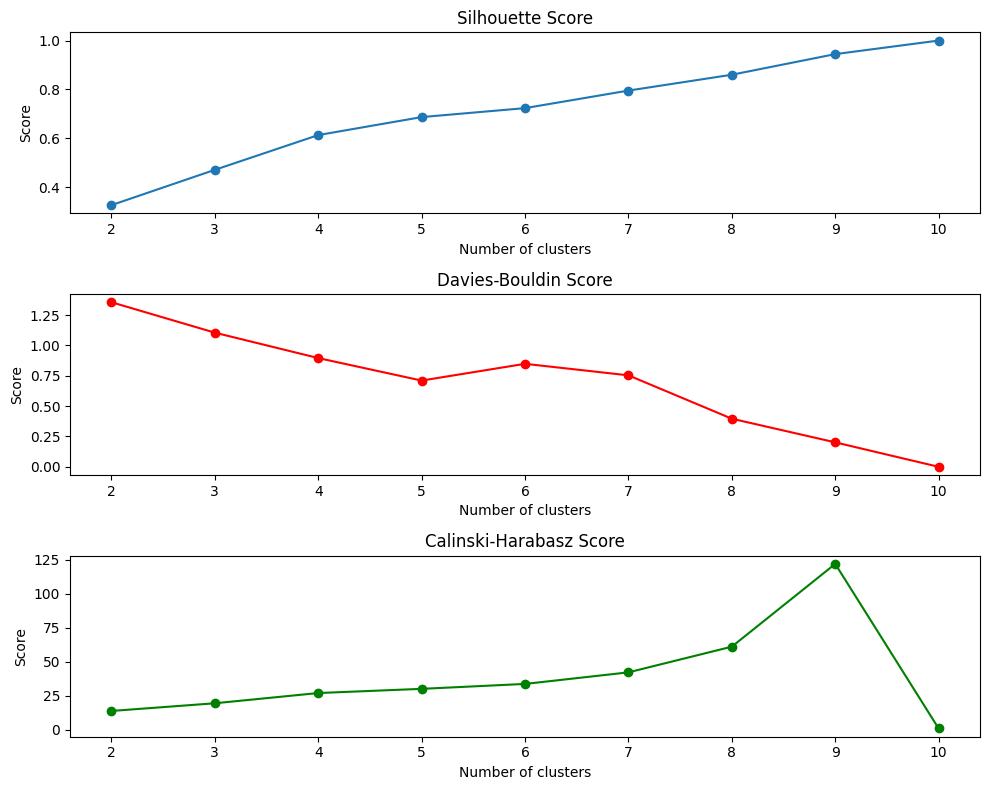

In [441]:
plot_clustering_scores(clustering_scores)

In [442]:
df = auto_process_id_assignment(df)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19332\961743608.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['process_id'] = process_ids


In [443]:
caminos_inicial = extraer_caminos(df)

In [444]:
df = eliminar_acciones_duplicadas(df, columna_label='activity_label')

In [445]:
fitness, precision, generalization, simplicity = petri_net_process(df)
bpmn_process(df)

aligning log, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

In [446]:
df[['Screenshot', 'header', 'activity_label', 'process_id']]

,Screenshot,header,activity_label,process_id
0,1_img.png,inbox (56) - antonio.martinez.ro,3,1
1,2_img.png,proof of payment - antonio.ma,8,1
2,3_img.png,odoo - customers,6,1
3,4_img.png,"odoo - azure interior, brandon",5,1
4,5_img.png,Zendesk,7,1
5,6_img.png,inbox (56) - antonio.martinez.ro,3,2
6,7_img.png,proof of payment - antonio.ma,8,2
7,8_img.png,odoo - customers,6,2
8,9_img.png,"odoo - azure interior, brandon",5,2
9,10_img.png,"odoo - azure interior, brandon",9,2


In [447]:
df.to_csv(os.path.join('results', 'df.csv'), index=False)

In [448]:
caminos_final = extraer_caminos(df)

In [449]:
caminos_inicial_set = set(caminos_inicial)

In [450]:
caminos_final_set = set(caminos_final.apply(tuple))
caminos_apriori_set = set(caminos_apriori_series.apply(tuple))

caminos_nuevos = caminos_final_set - caminos_apriori_set
caminos_no_descubiertos = caminos_apriori_set - caminos_final_set

porcentaje_nuevos = (len(caminos_nuevos) / len(caminos_final_set)) * 100 if caminos_final_set else 0
porcentaje_no_descubiertos = (len(caminos_no_descubiertos) / len(caminos_apriori_set)) * 100 if caminos_apriori_set else 0

In [451]:
print('Caminos a priori:', len(caminos_apriori)) # Caminos óptimos de mi proceso
print('Caminos iniciales:', len(caminos_inicial_set)) # Caminos obtenidos del primer modelos de datos
print('Caminos finales:', len(caminos_final_set)) # Caminos obtenidos después de aplicar post-procesado (eliminar duplicados de actividades)
print(f'Porcentaje de nuevos caminos: {porcentaje_nuevos:.2f}%') # Porcentaje de caminos que están presente en el modelo final pero no se encontraban en el modelo a priori
print(f'Caminos no descubiertos: {porcentaje_no_descubiertos:.2f}%') # Porcentaje de caminos que estaban en el modelo a priori pero no se encontraron en el modelo final

Caminos a priori: 4
Caminos iniciales: 4
Caminos finales: 4
Porcentaje de nuevos caminos: 100.00%
Caminos no descubiertos: 100.00%


In [452]:
def print_with_separator(text, separator='='):
    print(f"{text}\n{separator * len(text)}")

print_with_separator("\nParámetros de la ejecución")
print(f'Modelo empleado: {model}')
print(f'Peso texto: {text_weight}')
print(f'Peso imagen: {image_weight}')
print(f"Rango de clústeres: {n_clusters_range}")
print(f"Usar PCA: {use_pca}")
print(f"Número de componentes PCA: {n_components}")

print_with_separator("\nCaminos a priori")
print('Caminos a priori:', caminos_apriori)
print('Caminos iniciales:', caminos_inicial_set)
print('Caminos finales:', caminos_final_set)
print(f'Porcentaje de nuevos caminos: {porcentaje_nuevos:.2f}%')
print(f'Caminos no descubiertos: {porcentaje_no_descubiertos:.2f}%')

print_with_separator("\nMétricas a nivel del proceso (PM4PY)")
print(f"Fitness: {fitness['averageFitness']}")
print(f"Precisión: {precision}")
print(f"Generalización: {generalization}")
print(f"Simplicidad: {simplicity}")

print_with_separator("\nMétricas de clusterización")
print(f'Clusterización: {optimal_metrics}')


Parámetros de la ejecución
Modelo empleado: clip
Peso texto: 0.5
Peso imagen: 0.5
Rango de clústeres: (2, 11)
Usar PCA: False
Número de componentes PCA: 0.95

Caminos a priori
Caminos a priori: ((1, 0, 3, 2, 8, 4), (1, 0, 3, 2, 9), (1, 0, 3, 2, 6), (1, 0, 3, 2, 7))
Caminos iniciales: {(3, 8, 6, 5, 9), (3, 0, 6, 5, 2), (3, 8, 6, 5, 7), (3, 0, 6, 5, 4, 1)}
Caminos finales: {(3, 8, 6, 5, 9), (3, 0, 6, 5, 2), (3, 8, 6, 5, 7), (3, 0, 6, 5, 4, 1)}
Porcentaje de nuevos caminos: 100.00%
Caminos no descubiertos: 100.00%

Métricas a nivel del proceso (PM4PY)
Fitness: 1.0
Precisión: 0.7837837837837838
Generalización: 0.44038059222874415
Simplicidad: 0.7391304347826086

Métricas de clusterización
Clusterización: {'silhouette_score': 1.0, 'davies_bouldin_score': 0.0, 'calinski_harabasz_score': 1.0}


In [453]:
informacion = f"""
Parámetros de la ejecución
Modelo empleado: {model}
Peso texto: {text_weight}
Peso imagen: {image_weight}
Rango de clústeres: {n_clusters_range}
Usar PCA: {use_pca}
Número de componentes PCA: {n_components}

Descubrimiento de caminos
Caminos a priori: {caminos_apriori}
Caminos iniciales: {caminos_inicial_set}
Caminos finales: {caminos_final_set}
Porcentaje de nuevos caminos: {porcentaje_nuevos:.2f}%
Caminos no descubiertos: {porcentaje_no_descubiertos:.2f}%

Métricas a nivel del proceso (PM4PY)
Fitness: {fitness['averageFitness']}
Precisión: {precision}
Generalización: {generalization}
Simplicidad: {simplicity}

Métricas de clusterización
Clusterización: {optimal_metrics}
"""

# Escribe la información en el archivo
with open("results/execution.txt", "w") as archivo:
    archivo.write(informacion)


### Lanzar / Guardar ejecución

In [ ]:
caminos_apriori = ((1, 0, 3, 2, 8, 4),  
    (1, 0, 3, 2, 9),     
    (1, 0, 3, 2, 6),     
    (1, 0, 3, 2, 7))
caminos_apriori_series = pd.Series(list(caminos_apriori))

In [324]:
model = 'vgg' #clip or vgg
image_weight = 0.8
text_weight = 0.2
use_pca = True
n_clusters_range = (2, 11)
n_components = 0.95
referencia = False
asignacion = False

In [325]:
df = read_ui_log_as_dataframe('resources/sc_0_size50_Balanced/log_m.csv')

if model == 'clip':
    df = extract_features_from_images(df, 'Screenshot', 'header', image_weight, text_weight)
elif model == 'vgg':
    df = extract_features_from_VGG(df, 'resources/sc_0_size50_Balanced', 'Screenshot')

df, clustering_scores, optimal_cluster, optimal_metrics = cluster_images(df, n_clusters_range, use_pca, n_components)

if referencia:
    centroides_referencia = calcular_centroides(np.array(df['combined_features']), df['activity_label'].values)

if asignacion:
    reasignar_clusters_en_df(df, centroides_referencia)
    
df = auto_process_id_assignment(df)
caminos_inicial = extraer_caminos(df)
df = eliminar_acciones_duplicadas(df, columna_label='activity_label')

fitness, precision, generalization, simplicity = petri_net_process(df)
bpmn_process(df)

df.to_csv(os.path.join('results', 'df.csv'), index=False)

caminos_final = extraer_caminos(df)
caminos_inicial_set = set(caminos_inicial)

caminos_final_set = set(caminos_final.apply(tuple))
caminos_apriori_set = set(caminos_apriori_series.apply(tuple))

caminos_nuevos = caminos_final_set - caminos_apriori_set
caminos_no_descubiertos = caminos_apriori_set - caminos_final_set

porcentaje_nuevos = (len(caminos_nuevos) / len(caminos_final_set)) * 100 if caminos_final_set else 0
porcentaje_no_descubiertos = (len(caminos_no_descubiertos) / len(caminos_apriori_set)) * 100 if caminos_apriori_set else 0

informacion = f"""
Parámetros de la ejecución
Modelo empleado: {model}
Peso texto: {text_weight}
Peso imagen: {image_weight}
Rango de clústeres: {n_clusters_range}
Usar PCA: {use_pca}
Número de componentes PCA: {n_components}

Descubrimiento de caminos
Caminos a priori: {caminos_apriori}
Caminos iniciales: {caminos_inicial_set}
Caminos finales: {caminos_final_set}
Porcentaje de nuevos caminos: {porcentaje_nuevos:.2f}%
Caminos no descubiertos: {porcentaje_no_descubiertos:.2f}%

Métricas a nivel del proceso (PM4PY)
Fitness: {fitness['averageFitness']}
Precisión: {precision}
Generalización: {generalization}
Simplicidad: {simplicity}

Métricas de clusterización
Clusterización: {optimal_metrics}
"""

with open("results/execution.txt", "w") as archivo:
    archivo.write(informacion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━

aligning log, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

In [326]:
executions_dir = "executions"
results_dir = "results"

if not os.path.exists(executions_dir):
    os.makedirs(executions_dir)

existing_folders = [folder for folder in os.listdir(executions_dir) if folder.startswith('exec_')]
if existing_folders:
    highest_number = max([int(folder.split('_')[1]) for folder in existing_folders])
    next_exec_number = highest_number + 1
else:
    next_exec_number = 1

exec_subfolder = f"exec_{next_exec_number}"
path_subfolder = os.path.join(executions_dir, exec_subfolder)
os.makedirs(path_subfolder)

for filename in os.listdir(results_dir):
    source_file = os.path.join(results_dir, filename)
    destination_file = os.path.join(path_subfolder, filename)
    shutil.copy(source_file, destination_file)

print(f"Todos los archivos de '{results_dir}' han sido copiados a '{path_subfolder}'.")


Todos los archivos de 'results' han sido copiados a 'executions\exec_12'.


### Verificacion

In [103]:
# Inicializar variables globales
current_cluster_images = []
current_image_index = 0

# Widgets
cluster_selector = widgets.Dropdown(options=sorted(df['activity_label'].unique()), description='Filtra Cluster:')
image_display = widgets.Output()
thumbnails_display = widgets.Output(layout={'width': '100%', 'overflow': 'scroll'})
image_counter = widgets.Label()
assign_cluster_input = widgets.Text(value='', description='Asigna Cluster:')
next_button = widgets.Button(description='Siguiente Imagen')
prev_button = widgets.Button(description='Imagen Anterior')
assign_button = widgets.Button(description='Asignar a Cluster')
metrics_display = widgets.Label()

In [106]:
def display_thumbnails(cluster):
    """Muestra las miniaturas de todas las imágenes del cluster seleccionado, incluyendo la etiqueta de activity_manual si existe."""
    global current_cluster_images
    with thumbnails_display:
        clear_output(wait=True)
        plt.figure(figsize=(20, 3))
        for idx, img_index in enumerate(current_cluster_images):
            img_path = os.path.join('resources', 'sc_0_size50_Balanced', df.loc[img_index, 'Screenshot'])
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                plt.subplot(1, len(current_cluster_images), idx + 1)
                plt.imshow(img)
                # Verificar si la imagen tiene una etiqueta en activity_manual
                manual_label = df.loc[img_index, 'activity_manual']
                if pd.isna(manual_label) or manual_label == "":
                    title = f'#{idx+1} - NA'
                else:
                    title = f'#{idx+1} - {manual_label}'
                plt.title(title)
                plt.axis('off')
        plt.show()


def update_image_counter():
    """Actualiza el contador de imágenes para mostrar la posición actual en el cluster."""
    image_counter.value = f'Imagen {current_image_index + 1} de {len(current_cluster_images)}'

def display_current_image():
    """Muestra la imagen actual para la asignación de cluster."""
    global current_image_index
    with image_display:
        clear_output(wait=True)
        if current_cluster_images:
            img_path = os.path.join('resources', 'sc_0_size50_Balanced', df.loc[current_cluster_images[current_image_index], 'Screenshot'])
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
    update_image_counter()

def on_cluster_selected(change):
    """Actualiza la lista de imágenes y muestra las miniaturas al seleccionar un cluster."""
    global current_cluster_images, current_image_index
    current_cluster = change['new']
    current_cluster_images = df[df['activity_label'] == current_cluster].index.tolist()
    current_image_index = 0
    display_thumbnails(current_cluster)
    display_current_image()

def on_next_button_clicked(b):
    """Navega a la siguiente imagen del cluster."""
    global current_image_index
    if current_image_index < len(current_cluster_images) - 1:
        current_image_index += 1
    else:
        current_image_index = 0 
    display_current_image()

def on_prev_button_clicked(b):
    """Navega a la imagen anterior del cluster."""
    global current_image_index
    if current_image_index > 0:
        current_image_index -= 1
    else:
        current_image_index = len(current_cluster_images) - 1  # Opcional: ir al final si se desea un ciclo continuo
    display_current_image()

def on_assign_button_clicked(b):
    global current_cluster_images, current_image_index
    df.at[current_cluster_images[current_image_index], 'activity_manual'] = assign_cluster_input.value
    display_thumbnails(cluster_selector.value)
    
    # Calcular métricas después de cada asignación
    precision_actual = calcular_metricas()
    metrics_display.value = f'Precisión actual: {precision_actual:.2f}%'

def calcular_metricas():
    mapeo_manual_a_numerico = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}
    df['manual_numerico'] = df['activity_manual'].map(mapeo_manual_a_numerico)
    df['coincidencia'] = df['manual_numerico'] == df['activity_label']
    precision = df['coincidencia'].mean() * 100
    
    return precision


In [153]:
# Conexión de widgets a los botones
cluster_selector.observe(on_cluster_selected, names='value')
next_button.on_click(on_next_button_clicked)
prev_button.on_click(on_prev_button_clicked)
assign_button.on_click(on_assign_button_clicked)

# Mostrar los widgets
display(cluster_selector)
display(thumbnails_display)
display(image_display)
display(image_counter)
display(metrics_display)
display(widgets.HBox([prev_button, next_button, assign_cluster_input, assign_button]))

# Inicializar la visualización con el primer cluster
if df['activity_label'].unique().size > 0:
    current_cluster = cluster_selector.options[0]
    on_cluster_selected({'new': current_cluster})

Dropdown(description='Filtra Cluster:', index=4, options=(0, 1, 2, 3, 4), value=4)

Output(layout=Layout(overflow='scroll', width='100%'), outputs=({'traceback': ['\x1b--------------------…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x300 with 1 Axes>', '…

Label(value='Imagen 1 de 8')

Label(value='')

### Labbing

In [152]:
df['activity_manual'] = np.nan

In [18]:
df.to_csv('resources/sc_0_size50_Balanced/editar.csv', sep=';', index=False)

In [21]:
petri_net_process(read_ui_log_as_dataframe('resources/sc_0_size50_Balanced/editar.csv'))
bpmn_process(read_ui_log_as_dataframe('resources/sc_0_size50_Balanced/editar.csv'))